<h1>Финальный проект</h1>

Неделя 2

<h3>Часть 1. Загрузка и обработка данных</h3>

Загрузим данные за май и предобработаем, чтобы убрать аномалии. Код аналогичен тому, который был в задании прошлой недели.

In [1]:
import pandas as pd
raw = pd.read_csv('yellow_tripdata_2016-05.csv')
raw.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [2]:
#удаляем лишние столбцы
raw = raw.drop(['VendorID','RatecodeID','store_and_fwd_flag','payment_type',
                'fare_amount','extra','mta_tax','tip_amount','improvement_surcharge',
                'total_amount','tolls_amount'], axis=1)

In [3]:
import datetime
#парсим ячейки со временем
raw['tpep_dropoff_datetime'] = raw['tpep_dropoff_datetime'].map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
raw['tpep_pickup_datetime'] = raw['tpep_pickup_datetime'].map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

#считаем длительность поездки
raw['duration'] = raw['tpep_dropoff_datetime']-raw['tpep_pickup_datetime']

In [4]:
#удаляем поездки с нулевой длительностью
data = raw.loc[raw['duration'] != datetime.timedelta(0,0)]

#удаляем поездки с нулевым количеством пассажиров
data = data.loc[data['passenger_count'] != 0]

#удаляем поездки с нулевой дистанцией
data = data.loc[(data['trip_distance'] != 0) & (data['trip_distance'] < 100)]

#удаляем поездки с аномальными координатами
NY_coords = [[-74.25559, -73.70001],[40.49612, 40.91553]]
data = data.loc[(data['pickup_longitude'] > NY_coords[0][0]) &
             (data['pickup_longitude'] < NY_coords[0][1]) &
             (data['pickup_latitude'] > NY_coords[1][0]) &
             (data['pickup_latitude'] < NY_coords[1][1])]

data = data.loc[(data['dropoff_longitude'] > NY_coords[0][0]) &
             (data['dropoff_longitude'] < NY_coords[0][1]) &
             (data['dropoff_latitude'] > NY_coords[1][0]) &
             (data['dropoff_latitude'] < NY_coords[1][1])]

#добавим в данные столбец, содержащий количество часов от начала отсчета (00:00:00 01.05.2016)
data['pickup_hour'] = data['tpep_pickup_datetime'].map(lambda x: (x-datetime.datetime(2016,5,1)).total_seconds()/3600)

In [5]:
#считываем координаты ячеек
bins = pd.read_csv('regions.csv',sep=';')
bins.head()

#создаем сетку для агрегации
x_bins = list(bins.west[list(range(0,2499,50))])
y_bins = list(bins.south[list(range(0,50))])
x_bins.append(bins.east[2499])
y_bins.append(bins.north[49])
t_bins = list(range(0,(datetime.datetime(2016,6,1)-datetime.datetime(2016,5,1)).days*24))
t_bins.append(t_bins[-1]+1)

#агрегируем данные по регионам и часам
from scipy.stats import binned_statistic_dd
stat = binned_statistic_dd([data['pickup_longitude'].values,data['pickup_latitude']. values,data['pickup_hour'].values],None,'count',bins=[x_bins,y_bins,t_bins])


In [6]:
#Подсчитаем количество ячеек, из которых в мае не было ни одной поездки
empty_cells = 0
for i in range(50):
    for j in range(50):
        if sum(stat.statistic[i,j,:]) == 0:
            empty_cells += 1
print('Количество ячеек, из которых в мае не было ни одной поездки: '+str(empty_cells))

Количество ячеек, из которых в мае не было ни одной поездки: 1304


<h3>Часть 2. Статическая карта</h3>

Используем модуль basemap, чтобы нарисовать статическую карту

In [7]:
import os
os.environ["PROJ_LIB"] = "C:\\Users\\2\\Anaconda3\\Library\\share"; 

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
NY_map = Basemap(llcrnrlon=NY_coords[0][0],
              llcrnrlat=NY_coords[1][0],
              urcrnrlon=NY_coords[0][1],
              urcrnrlat=NY_coords[1][1],
              epsg=3627, resolution='f')

# Координаты  Empire State Building
target = (40.748441, -73.985664)

plt.annotate('Empire State Building', xy=NY_map(target[1], target[0]),
             xycoords='data',xytext=(100, 100),
             textcoords='offset points',
             color='r',
             size='large',
             arrowprops=dict(arrowstyle="fancy", color='r')
            )

NY_map.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1200, dpi=1600)

plt.show()

<Figure size 1000x1000 with 1 Axes>

In [8]:
import numpy as np
#Суммируем статистику по часам
stat_full = np.sum(stat.statistic, axis = 2)
stat_full.shape

(50, 50)

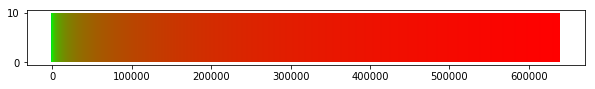

In [9]:
#cопоставим регионам цвета по количеству поездок. 
from math import log

maxnum = np.max(stat_full)

def linear_color(x,m):
    #вариант 1: линейный спектр от синего к красному    
    r = min(1,max(0,(2*x-m)/m))
    g = min(1,max(0,(m-abs(2*x-m))/m))
    b = min(1,max(0,(-2*x+m)/m))
    return r,g,b

def log_color(x):
    #вариант 2: логарифмический спектр от синего к красному    
    r,g,b = linear_color(log(x+1),log(maxnum))
    return r,g,b
#Вывод логарифмического спектра
rng = range(0,int(maxnum),10)
heatmap = list(map(log_color, rng))
plt.figure(figsize=(10, 1))
plt.vlines(rng, ymin = 0, ymax = 10, color = heatmap)

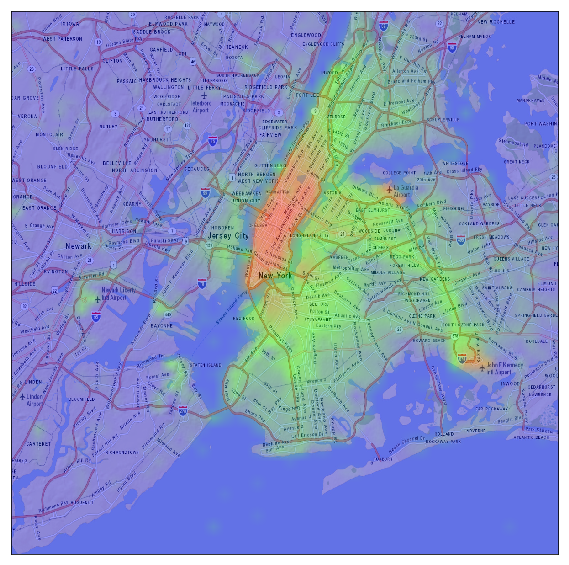

In [10]:
#Создаем цветовую карту
bincounts = stat_full.ravel(order = 'F')
colors = np.array(list(map(log_color,bincounts)))
colormap = colors.reshape(50,50,3)

#рисуем статическую карту Нью-Йорка
plt.figure(figsize = (10,10))
NY_heatmap = Basemap(llcrnrlon=NY_coords[0][0],
              llcrnrlat=NY_coords[1][0],
              urcrnrlon=NY_coords[0][1],
              urcrnrlat=NY_coords[1][1],
              epsg=3627, resolution='f')
NY_heatmap.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1200, dpi=1600)

#Рисуем поверх цветовую карту
NY_heatmap.imshow(colormap, alpha = 0.4, interpolation='bilinear')

plt.show()

Видим, что наибольшее кол-во поездок в районе аэропорта и на Манхеттене

<h3>Часть 3. Интерактивная карта</h3>

Используем модуль ipylefleat, чтобы нарисовать интерактивную карту

In [11]:
!jupyter nbextension enable --py --sys-prefix ipyleaflet
from ipyleaflet import *

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: ok


In [12]:
interactive_map = Map(center=(40.7, -73.9), zoom=10, basemap=basemaps.OpenStreetMap.Mapnik)

#координаты статуи свободы
interactive_map.add_layer(Marker(location=(40.689249, -74.044500)))

#Среднее кол-во поездок за час
stat_avg = np.mean(stat.statistic, axis=2)

#рисуем heatmap
dx = x_bins[1] - x_bins[0] 
dy = y_bins[1] - y_bins[0]
heatmap = [[[y_bins[i]+dy, x_bins[j]+dx, stat_avg[j,i]] for i in range(50)]for j in range(50)] 
heatmap = list(map(list,np.asarray(heatmap).reshape(2500,3)))
heat_layer = Heatmap(locations=heatmap,
                     radius=20, min_opacity=0, max=5, blur = 30)

interactive_map.add_layer(heat_layer)

interactive_map.add_control(LayersControl())

interactive_map

Map(center=[40.7, -73.9], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [13]:
#Отфильтруем ячейки, из которых в час в среднем меньше 5 поездок
counter = 0
for i in range(stat_avg.shape[0]):
    for j in range(stat_avg.shape[1]):
        if stat_avg[i,j] < 5:
            stat_avg[i,j] = 0
            counter += 1
print('Отфильтровано ячеек: ' + str(counter))

Отфильтровано ячеек: 2398


In [15]:
print('Осталось ячеек: ' + str(2500 - counter))

Осталось ячеек: 102


In [14]:
#Нарисуем оставшиеся ячейки более ярко, чтобы увидеть, если из каких-лиьо поездка невозможна

interactive_map = Map(center=(40.8, -73.9), zoom=10, basemap=basemaps.OpenStreetMap.Mapnik)

#Среднее кол-во поездок за час
stat_avg = np.mean(stat.statistic, axis=2)

#рисуем heatmap
dx = x_bins[1] - x_bins[0] 
dy = y_bins[1] - y_bins[0]
heatmap = [[[y_bins[i]+dy, x_bins[j]+dx, stat_avg[j,i]] for i in range(50)]for j in range(50)] 
heatmap = list(map(list,np.asarray(heatmap).reshape(2500,3)))
heat_layer = Heatmap(locations=heatmap,
                     radius=10, min_opacity=0, max=1, blur = 10)

interactive_map.add_layer(heat_layer)

interactive_map.add_control(LayersControl())

interactive_map

Map(center=[40.8, -73.9], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Похоже, все нормально. Кажется, что некоторые ячейки находятся в воде, но, скорее всего, это следствие низкого разрешения сетки агрегации. На самом деле, край ячейки цепляет берег.